In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import tqdm
import matplotlib.ticker as ticker
sns.set()

In [2]:
import sys
sys.path.insert(0, '../')
from model.seq2seq import Seq2Seq, tf
from model.decoding_techniques import BeamSearchDecoder, GreedyDecoder
from utils.processing_utils import *

1 Physical GPUs, 1 Logical GPUs


# Loading data and spliting

In [4]:
data_path = '../processed_data'
mode = 'glove'
if mode=='w2v':
    with open(os.path.join(data_path,'w2v_embeddings_cornell.npy'), 'rb') as f:
        final_embeddings = np.load(f)

    with open(os.path.join(data_path,'missing_in_w2v_cornell.npy'), 'rb') as f:
        missing = np.load(f)
elif mode=='glove':
    with open(os.path.join(data_path,'glove_embeddings_cornell.npy'), 'rb') as f:
        final_embeddings = np.load(f)

    with open(os.path.join(data_path,'missing_in_glove_cornell.npy'), 'rb') as f:
        missing = np.load(f)
elif mode=='custom':
    with open(os.path.join(data_path,'glove_embeddings_trained_cornell.npy'), 'rb') as f:
        final_embeddings = np.load(f)

    with open(os.path.join(data_path,'missing_in_glove_trained_cornell.npy'), 'rb') as f:
        missing = np.load(f)
        
with open(os.path.join(data_path,'token_mapping_cornell.json'), 'r') as f:
    token_mapping = json.load(f)

with open(os.path.join(data_path,'data_cornell.npy'), 'rb') as f:
    data = np.load(f,allow_pickle=True)  

In [5]:
missing_idx = [token_mapping[i] for i in missing]

In [6]:
len(data)

82957

In [7]:
inverse_token_mapping = dict((v,k) for k,v in token_mapping.items())
pad_token = inverse_token_mapping[0]
start_token = inverse_token_mapping[1]
end_token = inverse_token_mapping[2]
unk_token = inverse_token_mapping[3]

In [8]:
pad_token, start_token, end_token,unk_token

('<pad>', '<start>', '<end>', '<unk>')

In [9]:
test = data[2]
[test[i:i+2] for i in range(0,len(test)-1,1)]

[['no no it is my fault we did not have a proper introduction', 'Cameron .'],
 ['Cameron .',
  'the thing is Cameron i am at the mercy of a particularly hideous breed of loser . my sister . i cannot date until she does .'],
 ['the thing is Cameron i am at the mercy of a particularly hideous breed of loser . my sister . i cannot date until she does .',
  'seems like she could get a date easy enough .']]

In [10]:
def slice_data(data):
    X, y = [], []
    for conversation in data:
        pairs = np.array([conversation[i:i+2] for i in range(0,len(conversation)-1,1)])
        X.extend(list(pairs[:,0]))
        y.extend(list(pairs[:,1]))
    return X, y

In [11]:
X, y = slice_data(data)

In [12]:
len(X), len(y)

(221068, 221068)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, shuffle=True)

In [14]:
len(X_train), len(X_test)

(187907, 33161)

In [15]:
def map_to_ids(x, mapping, end_token=None, start_token=None, padding_token=None, max_len=None):
  if isinstance(x, str):
    x = x.split(' ')
  max_len = max_len if max_len else len(x)
  if start_token:
    x = [start_token] + x
  sent_ids = [mapping[word] for word in x[:max_len]]
  if max_len>len(x):
      if end_token:
        sent_ids.append(mapping[end_token])
      if padding_token:
        sent_ids += [mapping[padding_token]]*(max_len-len(sent_ids))
      return sent_ids
  if end_token:
    sent_ids[-1] = mapping[end_token]
  return sent_ids


In [16]:
max_len_tokens = 20

In [17]:
X_train_enc = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in X_train])
X_test_enc = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in X_test])
X_train_dec = np.array([map_to_ids(i, token_mapping, None, start_token, pad_token, max_len_tokens) for i in y_train])
X_test_dec = np.array([map_to_ids(i, token_mapping, None, start_token, pad_token, max_len_tokens) for i in y_test])
y_train = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in y_train])
y_test = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in y_test])


In [18]:
X_train_dec[0], y_train[0]

(array([    1, 17644, 27660, 29945, 18809, 17644,  8875, 25161,     7,
        17644, 29595, 21886, 29945, 17689, 29945, 19210,     7, 10803,
         3510, 29792]),
 array([17644, 27660, 29945, 18809, 17644,  8875, 25161,     7, 17644,
        29595, 21886, 29945, 17689, 29945, 19210,     7, 10803,  3510,
        29792,     2]))

# Building a model 

In [19]:
final_embeddings.shape

(30003, 100)

In [20]:
seq2seq = Seq2Seq(token_mapping, 
         pad_token=token_mapping[pad_token],
         end_token=token_mapping[end_token],
         start_token=token_mapping[start_token],
         max_len=max_len_tokens,
         embeddings=final_embeddings,
         embedding_prefix=mode,
         missing_tokens=np.array(missing_idx).astype(np.int32),
        )

# Training a model

In [21]:
train_data = tf.data.Dataset.from_tensor_slices((X_train_enc, X_train_dec, y_train))
val_data = tf.data.Dataset.from_tensor_slices((X_test_enc, X_test_dec, y_test))

In [22]:
batch_size = 256
num_epochs = 100
epochs_patience = 20

In [ ]:
seq2seq.fit(train_data,
            validation_dataset=val_data,
            steps_per_epoch=X_train_enc.shape[0]//batch_size,
            batch_size=batch_size,
            num_epochs=num_epochs,
            epochs_patience=epochs_patience,
           experiment_name='cornell')

  0%|          | 0/100 [00:00<?, ?it/s]

Made dir : models
Instructions for updating:
Use tf.identity instead.


# Testing predictions and other helpful stuff

In [21]:
from utils.model_utils import plot_attention

In [22]:
def process(x, unk_token):
  res = []
  for i in x.split(' '):
    if token_mapping.get(i):
      res.append(i)
    elif token_mapping.get(i.lower()):
      res.append(i.lower())
    else:
      res.append(unk_token)
  return res

In [23]:
def give_answer(decoder, sentence, inverse_token_mapping, pad_unk=True, process_sentence=True, len_output=50,
               beam_size=3,
               beam_search=False,
               show_attention=False):
      if process_sentence:
        cleaned_sentence = uncover_reduction(clean_bad_chars(sentence))
        unk_token = pad_token if pad_unk else "<unk>"
        processed_sentence = process(cleaned_sentence, unk_token)
        mapped_sentence = map_to_ids(processed_sentence, token_mapping, end_token, padding_token=pad_token, max_len=max_len_tokens)
      else:
        mapped_sentence = sentence
      if beam_search:
        prediction = decoder.decode(mapped_sentence, beam_size)
      else:
          prediction = decoder.decode(mapped_sentence, len_output, show_attention)
      if show_attention and not beam_search:
        prediction, attention = prediction
      answer = " ".join([inverse_token_mapping.get(i) for i in prediction]).capitalize()
      if show_attention and not beam_search:
            plot_attention(attention,sentence.split(' '), answer.split(' '))
      return answer

In [36]:
greedy_decoder = GreedyDecoder(decoder=seq2seq.decoder,
             encoder=seq2seq.encoder,
             max_len=max_len_tokens,
             start_token=token_mapping[start_token],
             end_token=token_mapping[end_token])

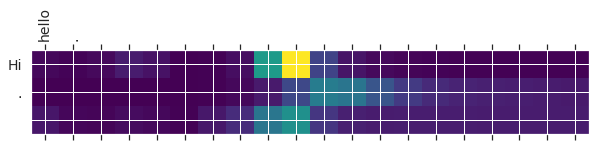

'Hi .'

In [42]:
give_answer(greedy_decoder, 'hello .', inverse_token_mapping, show_attention=True)

In [39]:
beam_search_decoder = BeamSearchDecoder(decoder=seq2seq.decoder, 
                 encoder=seq2seq.encoder,
                 max_len=max_len_tokens,
                 start_token=token_mapping[start_token],
                 end_token=token_mapping[end_token])

In [43]:
give_answer(beam_search_decoder, 'hi .', inverse_token_mapping, show_attention=False,
           beam_search=True)

'Hi .'

# Dialogue generation and question answering

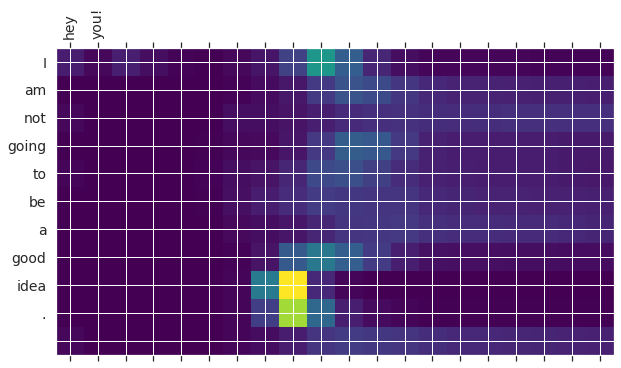

------------------------------
Test replica : hey you!
Bot greedy answer : I am not going to be a good idea .
Bot beam search answer : What ?
------------------------------


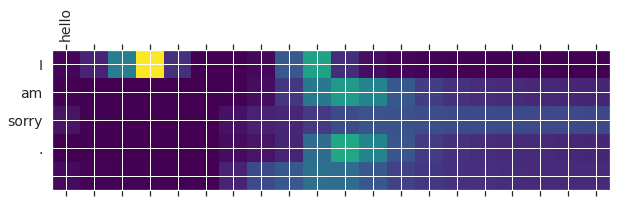

------------------------------
Test replica : hello
Bot greedy answer : I am sorry .
Bot beam search answer : Hi .
------------------------------


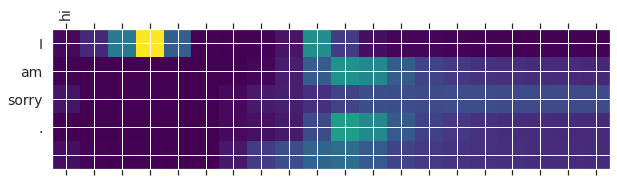

------------------------------
Test replica : hi
Bot greedy answer : I am sorry .
Bot beam search answer : Hi .
------------------------------


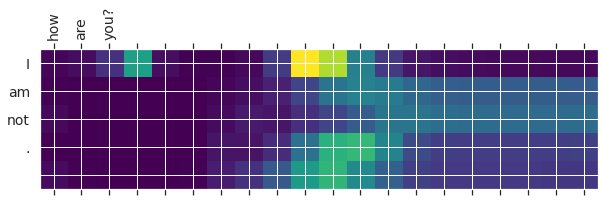

------------------------------
Test replica : how are you?
Bot greedy answer : I am not .
Bot beam search answer : I do not know .
------------------------------


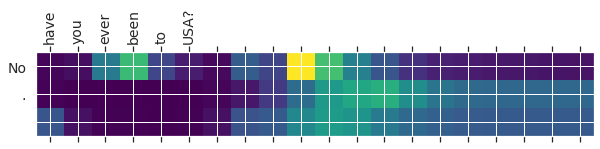

------------------------------
Test replica : have you ever been to USA?
Bot greedy answer : No .
Bot beam search answer : Yes .
------------------------------


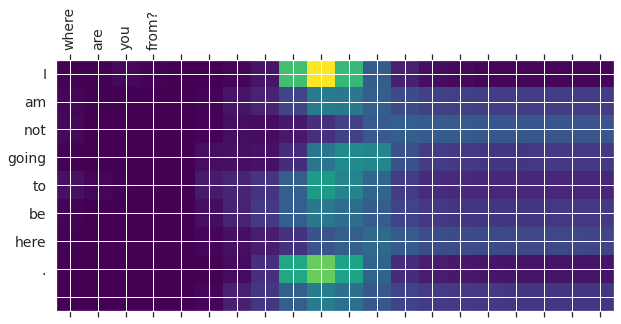

------------------------------
Test replica : where are you from?
Bot greedy answer : I am not going to be here .
Bot beam search answer : I do not know .
------------------------------


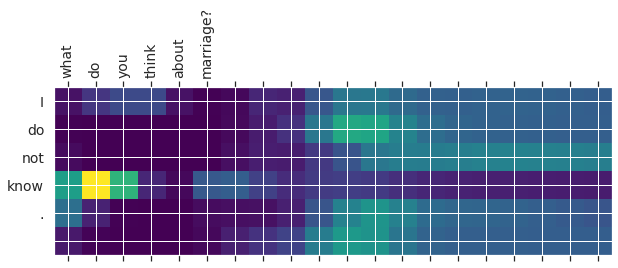

------------------------------
Test replica : what do you think about marriage?
Bot greedy answer : I do not know .
Bot beam search answer : I do not know .
------------------------------


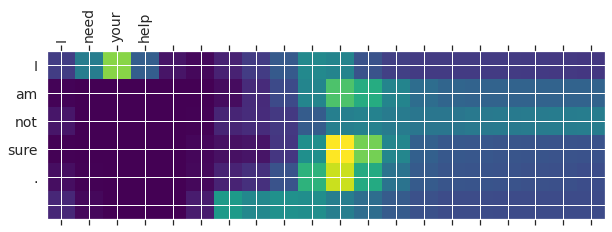

------------------------------
Test replica : I need your help
Bot greedy answer : I am not sure .
Bot beam search answer : I do not want to do it .
------------------------------


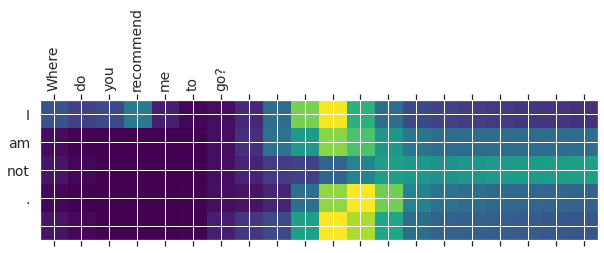

------------------------------
Test replica : Where do you recommend me to go?
Bot greedy answer : I am not .
Bot beam search answer : Yes .
------------------------------


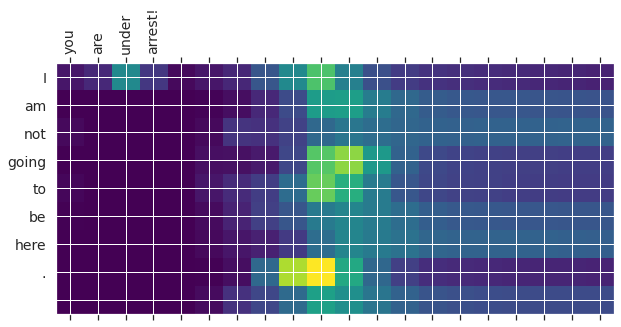

------------------------------
Test replica : you are under arrest!
Bot greedy answer : I am not going to be here .
Bot beam search answer : I do not know .
------------------------------


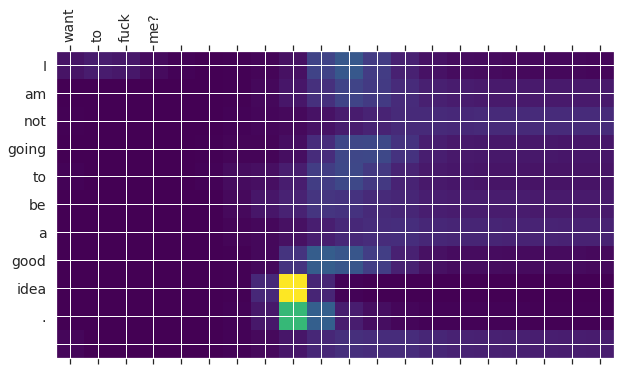

------------------------------
Test replica : want to fuck me?
Bot greedy answer : I am not going to be a good idea .
Bot beam search answer : I do not know .
------------------------------


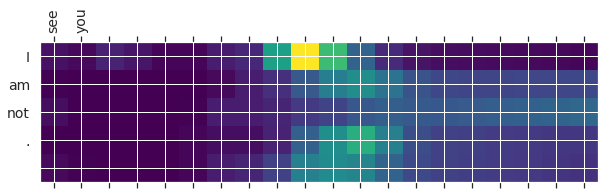

------------------------------
Test replica : see you
Bot greedy answer : I am not .
Bot beam search answer : Yes .
------------------------------


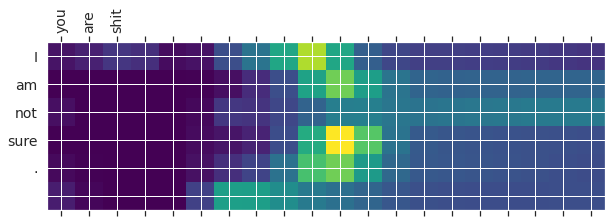

------------------------------
Test replica : you are shit
Bot greedy answer : I am not sure .
Bot beam search answer : I do not know .
------------------------------


In [79]:
replicas = ['hey you!',
            'hello',
            'hi',
            'how are you?',
            'have you ever been to USA?',
            'where are you from?',
            'what do you think about marriage?',
             'I need your help',
           'Where do you recommend me to go?',
           'you are under arrest!',
           'want to fuck me?',
           'see you',
           'you are shit']
for i in replicas:
    greedy_answer = give_answer(greedy_decoder, i, inverse_token_mapping, show_attention=True)
    beam_search_answer = give_answer(beam_search_decoder, i, inverse_token_mapping,
           beam_search=True,
           beam_size=3)
    print(30*'-')
    print('Test replica : {}'.format(i))
    print('Bot greedy answer : {}'.format(greedy_answer))
    print('Bot beam search answer : {}'.format(beam_search_answer))
    print(30*'-')


# Interactive usage

In [45]:
inp = ''
while True:
    inp = str(input()).strip()
    if inp=='exit':
        break
    greedy_answer = give_answer(greedy_decoder, inp, inverse_token_mapping, show_attention=False)
    beam_search_answer = give_answer(beam_search_decoder, inp, inverse_token_mapping,
           beam_search=True,
           beam_size=7)
    print(30*'-')
    print('Replica : {}'.format(inp))
    print('Beam answer : {}'.format(beam_search_answer))
    print('Greedy answer : {}'.format(greedy_answer))
    print(30*'-')

hi
------------------------------
Replica : hi
Beam answer : What ?
Greedy answer : I am sorry .
------------------------------
hi .
------------------------------
Replica : hi .
Beam answer : Hi .
Greedy answer : Hi .
------------------------------
what is it?
------------------------------
Replica : what is it?
Beam answer : I do not know .
Greedy answer : I am not going to be a good idea .
------------------------------
how are you, bastard?
------------------------------
Replica : how are you, bastard?
Beam answer : I do not know .
Greedy answer : I am not .
------------------------------
well well
------------------------------
Replica : well well
Beam answer : That is that ?
Greedy answer : I am sorry .
------------------------------
hell yeah
------------------------------
Replica : hell yeah
Beam answer : What ?
Greedy answer : I am not going to be a good idea .
------------------------------
how often do you jerk off?
------------------------------
Replica : how often do you j

KeyboardInterrupt: Interrupted by user